In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Flatten

Using TensorFlow backend.
F:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
F:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
F:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
F:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import json

ModuleNotFoundError: No module named 'geopandas'

In [ ]:
#ddf = pd.read_csv('./goodData.csv',nrows = 50)
#ddf['traj'] = json.loads('[' + ddf.POLYLINE.str.cat(sep=',') + ']')
#ddf['check'] = df.traj.apply(lambda x: all(\
#                [t>-8.72 for t in np.transpose(x)[0]]) and all([t<-8.52 for t in np.transpose(x)[0]] and \
#                [t>41.08 for t in np.transpose(x)[1]]) and all([t>-41.27 for t in np.transpose(x)[1]]))

In [ ]:
from shapely.geometry import LineString, Point
def load_data(fname, nrows,lat_filter=(41.08,41.27),long_filter=(-8.72,-8.52)):
    df = pd.read_csv(fname, nrows=nrows)

    df['traj'] = json.loads('[' + df.POLYLINE.str.cat(sep=',') + ']')
    df = df[df.traj.str.len() > 1].copy()
    df['lines'] = gpd.GeoSeries(df.traj.apply(LineString))
    df['check'] = df.traj.apply(lambda x: all(\
                [t>long_filter[0] for t in np.transpose(x)[0]]) and all([t<long_filter[1] for t in np.transpose(x)[0]]) and \
                all([t>lat_filter[0] for t in np.transpose(x)[1]]) and all([t<lat_filter[1] for t in np.transpose(x)[1]]))
    df=df[df.check]
    df = df.drop(columns=['check'])
    
    return gpd.GeoDataFrame(df, geometry='lines')


In [ ]:
#, (-1000,1000),(-1000,1000)
df = load_data('./goodData.csv',100000)
df.head()


In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15,8]
import seaborn as sns
sns.set(style="darkgrid")

In [ ]:
#plot trajectory
df.lines.iloc[:1000].plot(figsize=[15,15]);
plt.xlabel('Longitude')
plt.ylabel('Latitude');
plt.show()

In [ ]:
'''
df = pd.read_csv('./goodData.csv')
vl = json.loads('[' + df.POLYLINE.str.cat(sep=',') + ']')
maxp = 3837
ft = []
for fn in range(maxp):
  f = open("./splitedData/"+str(fn)+".txt","a")
  ft.append(f)


count=1
for v in vl:
  count+=1
  if count%10000 ==0:
    print(count)
  pnum = len(v)
  ft[pnum].write(str(v))
  ft[pnum].write('\n')
  
for f in ft:
  f.close()
  
print('all done')
'''

In [ ]:
lat_mid= 41.08
lat_range = ((-41.08+41.27))
long_mid = -8.72
long_range = (8.72-8.52)
def scale_to_01(val):
    newD = []
    for v in val:
        x = (v[0]-long_mid)/long_range
        y = (v[1]-lat_mid)/lat_range
        newD.append([x,y])
    return newD
    
    
def create_dataset(dataset, look_back=1):
    dataset = scale_to_01(dataset)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return dataX,dataY

In [ ]:
vl = json.loads('[' + df.POLYLINE.str.cat(sep=',') + ']')
ft = []
prevSteps = 50
X,Y = [], []
count=1
for v in vl:
    count+=1
    if count%10000 ==0:
        print(count)
    pnum = len(v)
    if pnum > prevSteps:
        dx,dy = create_dataset(v,prevSteps)
        X.extend(dx)
        Y.extend(dy)
X=np.array(X)
Y=np.array(Y)
print(X,Y)
print('all done')

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
X_train

In [404]:
model = Sequential()
model.add(LSTM(units=88, input_shape=(prevSteps,2),return_sequences=False))
model.add(Dense(2,activation='relu'))
model.summary()


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 88)                32032     
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 178       
Total params: 32,210
Trainable params: 32,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import optimizers
epochs = 10

model.compile(optimizer=optimizers.RMSprop(lr=0.0001),loss = 'binary_crossentropy',metrics=['mse'])
history = model.fit(X_train,Y_train,epochs=epochs,batch_size=32, validation_data=(X_test,Y_test))

Epoch 1/10
15503/16464 [===========================>..] - ETA: 28s - loss: 0.6405 - mse: 1.1055e-04

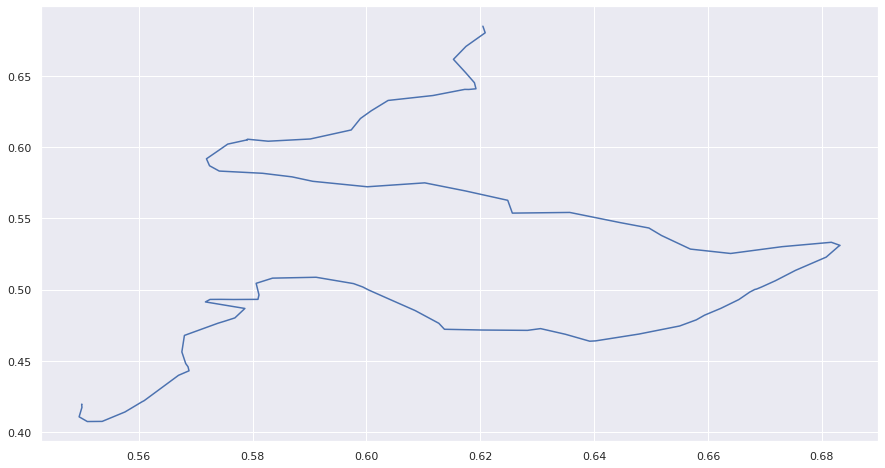

In [393]:
from random import randint
def createLineList(m,datas):
    #print (datas)
    ts = datas[m-1].replace('[','').replace(']','').strip()
    trajectory = ts.split(',')
    ret = []
    for i in range(0,len(trajectory)-1,2):
        ret.append([float(trajectory[i]),float(trajectory[i+1])])
            
    return ret

def getRandomSampleData(n):
    fname = './splitedData/'+str(n)+'.txt'
    ret=[]
    with open(fname,'r') as file:
        datas = file.readlines()
        if len(datas)==0:
            print("The select data not available")
            return getRandomSampleData(100)
        di = randint(1,len(datas)-1)
        
        data = createLineList(di,datas)
        return scale_to_01(data)

selected = getRandomSampleData(100)
orig = np.transpose(np.array(selected)).tolist()
plt.plot(orig[0],orig[1])

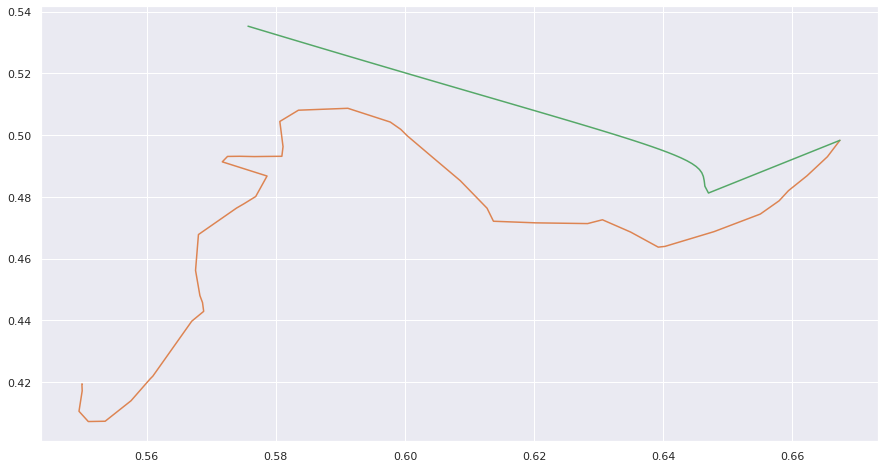

In [394]:

def getPlotList_usePredAsInput(st):
    initData = st[:prevSteps]
    restSteps = len(st)-prevSteps
    for i in range(restSteps):
        arr = np.array([initData[-prevSteps:]])
        #print(arr.shape)
        yNew = model.predict(arr)
        #print(yNew.shape)
        #print(yNew)
        initData.append(yNew.tolist()[0])
    return initData
trajAfterPred = getPlotList_usePredAsInput(selected)
#print (trajAfterPred)
trajLine = np.transpose(np.array(trajAfterPred)).tolist()
plt.plot(trajLine[0][:prevSteps],trajLine[1][:prevSteps],'C1')
plt.plot(trajLine[0][prevSteps-1:],trajLine[1][prevSteps-1:],'C2')

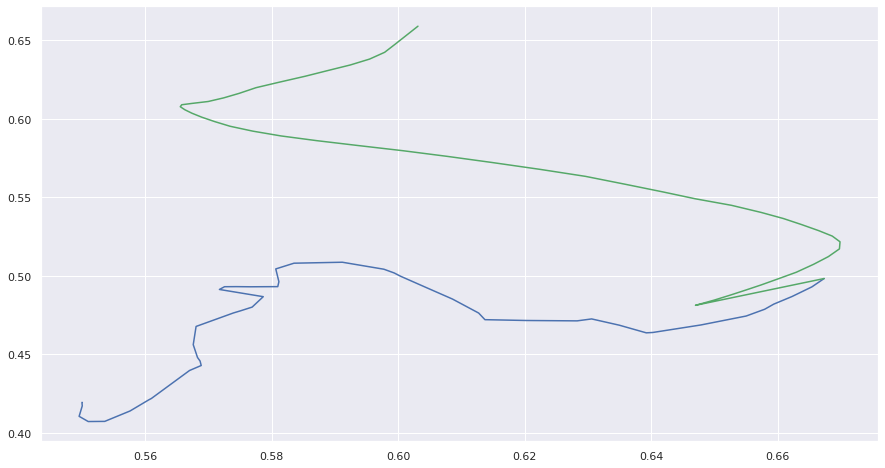

In [395]:
import copy
def getPlotList_useKnownTraj(st):
    ret = copy.deepcopy(st[:prevSteps])
    for i in range(prevSteps,len(st)):
        arr = np.array([st[i-prevSteps:i]])
        #print(arr.shape)
        yNew = model.predict(arr)
        ret.append(yNew.tolist()[0])
    return ret
tt = getPlotList_useKnownTraj(selected)
#print (trajAfterPred)
tl = np.transpose(np.array(tt)).tolist()
plt.plot(tl[0][:prevSteps],tl[1][:prevSteps])
plt.plot(tl[0][prevSteps-1:],tl[1][prevSteps-1:],'C2')